<a href="https://colab.research.google.com/github/RutujKhare1/CS6910_Assignment_1/blob/main/FDL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=22d898c3632c9f7faa2a99bb5e40db3a60c840e4c828124c07238988242ba5d2
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [ ]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import wandb

In [ ]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
num_label = 10
num_samples = len(X_train)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print("Train shape : {}, {}".format(X_train.shape, Y_train.shape))
print("Test shape : {}, {}".format(X_test.shape, Y_test.shape))

Train shape : (60000, 28, 28), (60000,)
Test shape : (10000, 28, 28), (10000,)


# Question 1

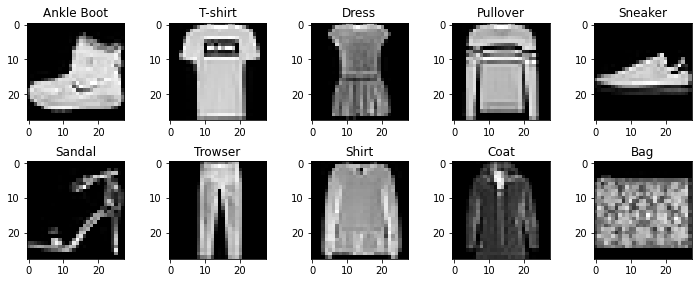

In [ ]:
num_row = 2
num_col = 5

cnt = 30
images = X_train[:cnt]
labels = Y_train[:cnt]
dic = {0:'T-shirt', 1:'Trowser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

visited = [True for i in range(10)]
r_idx = 0
c_idx = 0
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col, 2*num_row))
for i in range(cnt):
  if(visited[labels[i]]):
    if(c_idx == num_col):
      r_idx = 1
      c_idx = 0
    visited[labels[i]] = False
    ax = axes[r_idx, c_idx]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('{}'.format(dic[labels[i]]))
    c_idx += 1 
plt.tight_layout()
plt.show()

#Question 2

In [ ]:
#Helper functions

def xavierRandom(x, y):
  limit = np.sqrt(6 / float(x + y))
  return np.random.uniform(low=-limit, high=limit, size=(x,y))
  

In [ ]:
#activation functions

def sigmoid(x):
  z = x.copy()
  z[x < 0] = np.exp(x[x < 0])/(1 + np.exp(x[x<0]))
  z[x >= 0] = 1/(1+np.exp(-x[x >= 0]))
  return z

def d_sigmoid(x):
  return sigmoid(x)*(1 - sigmoid(x))

def softmax(x):
  e_x = np.exp(x - max(x))
  return e_x / e_x.sum()

def tanh(x):
  return np.tanh(x)
  
def d_tanh(x):
  return 1 - tanh(x)**2

def relu(x):
  return np.maximum(x,0)

def d_relu(x):
  z = x.copy()
  z[x < 0]=0
  z[x > 0]=1
  return z

actFn_dict = {"sigmoid":sigmoid,
               "softmax":softmax,
               "relu":relu,
               "tanh":tanh}
d_actFn_dict = {"sigmoid":d_sigmoid,
               "relu":d_relu,
               "tanh":d_tanh}


In [ ]:
class Optimizer:
  def forwardPropagation(self, W, B, X, num_layer, activation):
    H=list()
    A=list()
    a = np.array(W[0]@X.T + B[0])
    h = actFn_dict[activation](a)
    H.append(h)
    A.append(a)
    cur_ip = h

    for i in range(num_layer-1):
      a = np.array(W[i+1]@cur_ip + B[i+1])
      h = actFn_dict[activation](a.T).T
      H.append(h)
      A.append(a)
      cur_ip = h
    a = np.array(W[num_layer]@cur_ip + B[num_layer])
    h = a.T
    A.append(a)
    y = np.array([actFn_dict["softmax"](i) for i in h]).T
    return H, A, y

  def backwardPropagation(self, H, A, y, W, B, X, Y, num_layer, num_label, activation):
    xdim = X.shape[0]
    ey = np.zeros([xdim,num_label], dtype= int)
    for i in range(xdim):
      ey[i][Y[i]] = 1
    d_aL = -(ey.T - y)   #(60000, 10)
    D_W = list()
    D_B = list()
    for k in reversed(range(1,num_layer+1)):
      # print("k:",k)
      # print("d_aL : ",d_aL.shape)
      # print("h_k-1 : {}x{}".format(len(H[k-1]), len(H[k-1][0])))
      d_wL = d_aL@H[k-1].T
      D_W.append(d_wL/xdim)

      # print("d_wL : ",d_wL.shape)
      
      d_bL = np.sum(d_aL, axis = 1).reshape(len(d_aL),1)/xdim
      D_B.append(d_bL)
      
      # print("W[k] : ",W[k].shape)
      
      d_hL = W[k].T@d_aL
      dga = d_actFn_dict[activation](A[k-1])
      
      # print("d_hL : ",d_hL.shape)
      # print("dga : ",dga.shape)
      
      d_aL = np.multiply(d_hL,dga)
      
      # print("d_aL : ",d_aL.shape)
      # print("\n")

    d_wL = d_aL @ X
    d_bL = d_aL
    d_bL = np.sum(d_bL, axis = 1).reshape(len(d_aL),1)/xdim
    D_W.append(d_wL/xdim)
    D_B.append(d_bL)
    return D_W, D_B
    # print(d_aL.shape)
    # print(H[3].shape)
    # d_wL = d_aL@H[3].T
    # d_bL = d_aL
    # d_hL = W[4]@d_aL
    # dga = d_sigmoid(A[3])
    # d_aL = d_hL@dga

In [ ]:
X_mini = np.reshape(X_train, (60000,784))/255.0
num_data_points = 60000
num_labels = 10
num_val_points = num_data_points//10
num_train_points = num_data_points - num_val_points
Xtrain = X_mini[:num_train_points]
Ytrain = Y_train[:num_train_points]
X_valid = X_mini[num_train_points:]
Y_valid =  Y_train[num_train_points:]

In [ ]:
class feedforwardNeuralNetwork:
  def __init__(self, num_layers = 3, hidden_size = 64, num_labels = 10, neta = 0.1, epochs = 10, X_train = X_train, Y_train = Y_train, batch = 64, w_init = "xavier", X_val = X_valid, Y_val = Y_valid, activation = 'sigmoid', wt_decay = 0):
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.xdim = X_train.shape[0]
    self.ydim = X_train.shape[1]
    self.num_labels = num_labels
    self.neta = neta
    self.epochs = epochs
    self.X_train = X_train
    self.Y_train = Y_train
    self.X_val = X_val
    self.Y_val = Y_val
    self.batch = batch
    w, b = self.initialiseWeight(w_init)
    self.W = w
    self.B = b
    self.activation = activation
    self.wt_decay = wt_decay
  
  def initialiseWeight(self, method):
    w = list()
    b = list()
    if(method == "xavier"):
      w.append(xavierRandom(self.hidden_size, self.ydim))
      b.append(np.zeros([self.hidden_size,1]))
      for i in range(self.num_layers-1):
        w.append(xavierRandom(self.hidden_size, self.hidden_size))
        b.append(np.zeros([self.hidden_size,1]))
      w.append(xavierRandom(self.num_labels, self.hidden_size))
      b.append(np.zeros([self.num_labels,1]))
    else:
      # w.append(np.random.randn(hidden_size, ydim))
      w.append(np.random.uniform(-1,1, (self.hidden_size, self.ydim)))

      # b.append(np.random.randn(hidden_size,1))
      b.append(np.zeros([self.hidden_size,1]))
      for i in range(self.num_layers-1):
        # w.append(np.random.randn(hidden_size, hidden_size))
        w.append(np.random.uniform(-1,1, (self.hidden_size, self.hidden_size)))
        # b.append(np.random.randn(hidden_size,1))
        b.append(np.zeros([self.hidden_size,1]))
      # w.append(np.random.randn(num_labels, hidden_size))
      w.append(np.random.uniform(-1,1, (self.num_labels, self.hidden_size)))
      # b.append(np.random.randn(num_labels,1))
      b.append(np.zeros([self.num_labels,1])) 
    return w, b

  def calculateLoss(self, y_hat, Y):
    num_data = y_hat.shape[1]
    Y_one_hot = np.eye(self.num_labels)[Y]
    loss = -np.sum(Y_one_hot * np.log(y_hat.T + 1e-15) )
    return (loss/num_data)

  def mse(self, y_hat, Y):
    m,n = y_hat.shape
    Y_one_hot = np.eye(self.num_labels)[Y]
    diff_matrix = (y_hat - Y_one_hot)**2
    loss = np.sum(diff_matrix)
    return loss/(m*n)

  def calculateAccuracy(self, y_hat, Y):
    pred = np.argmax(y_hat, axis=0)
    accuracy = np.mean(pred==Y)
    return accuracy*100

  def feedForward(self, x):
    a = np.array(self.W[0]@x.T + self.B[0])
    h = actFn_dict[self.activation](a.T).T
    cur_ip = h

    for i in range(self.num_layers-1):
      a = np.array(self.W[i+1]@cur_ip + self.B[i+1])
      h = actFn_dict[self.activation](a.T).T
      cur_ip = h
    a = np.array(self.W[self.num_layers]@cur_ip + self.B[self.num_layers])
    h = a.T
    # print(h)
    y = np.array([actFn_dict["softmax"](i) for i in h]).T
    # print(y)
    return y

  # def gradientDescent(self):
  #   for k in range(self.epochs):
  #     O = Optimizer()
  #     H, A, y = O.forwardPropagation(self.W, self.B, self.X_train, self.num_layers)
  #     D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, self.X_train, self.Y_train, self.num_layers, self.num_labels)
  #     D_W = np.flip(D_W)
  #     D_B = np.flip(D_B)
  #     # print(self.B[0].shape)
  #     # print(D_B[0].shape)
  #     for i in range(self.num_layers+1):
  #       self.W[i] = self.W[i] - self.neta*D_W[i]
  #       self.B[i] = self.B[i] - self.neta*D_B[i] 
      
  #     y_hat = self.feedForward(self.X_train)
  #     Y_one_hot = np.eye(self.num_labels)[self.Y_train]
  #     loss = -np.sum(Y_one_hot * np.log(y_hat.T + 1e-15) )
  #     print("Epoch {} : {}".format(k, (loss/self.xdim)))
  

  def momentumGD(self, beta = 0.9, eta = 1.0):
    # print("neta ",self.neta)
    O = Optimizer()
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
        D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation)
        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        if k==0:
          uw = D_W
          ub = D_B
        else:
          uw = beta*prev_uw + eta*D_W
          ub = beta*prev_ub + eta*D_B
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta*uw[i] - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta*ub[i] - self.neta*self.wt_decay*self.B[i]
        prev_uw = uw
        prev_ub = ub 
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_loss.append(self.calculateLoss(y_train_hat, self.Y_train))
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      # print("Epoch {} : Loss:{}\t Accuracy:{}".format(k, train_loss[-1], train_acc[-1]))
      val_loss.append(self.calculateLoss(y_val_hat, self.Y_val))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
    return train_loss, train_acc, val_loss, val_acc

  def nagGD(self, beta = 0.1, eta = 1.0):
    O = Optimizer()
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        if k==0:
          H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
          D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation)
        else:
          u_w = beta*prev_uw
          u_b = beta*prev_ub
          temp_u_w = list()
          temp_u_b = list()
          for i in range(len(self.W)):
            temp_u_w.append(self.W[i]-u_w[i])
            temp_u_b.append(self.B[i]-u_b[i])  
          H, A, y = O.forwardPropagation(temp_u_w, temp_u_b, X_batch, self.num_layers, self.activation)
          D_W, D_B = O.backwardPropagation(H, A, y, temp_u_w, temp_u_b, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation)

        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        if k==0:
          uw = D_W
          ub = D_B
        else:
          uw = beta*prev_uw + eta*D_W
          ub = beta*prev_ub + eta*D_B
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta*uw[i] - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta*ub[i] - self.neta*self.wt_decay*self.B[i]
        prev_uw = uw
        prev_ub = ub 
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_loss.append(self.calculateLoss(y_train_hat, self.Y_train))
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      # print("Epoch {} : Loss:{}\t Accuracy:{}".format(k, train_loss[-1], train_acc[-1]))
      val_loss.append(self.calculateLoss(y_val_hat, self.Y_val))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
    return train_loss, train_acc, val_loss, val_acc
    
  
  def stochasticGD(self):
    O = Optimizer()
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
        D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation)
        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        # print(self.B[0].shape)
        # print(D_B[0].shape)
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta*D_W[i] - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta*D_B[i] - self.neta*self.wt_decay*self.B[i]
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_loss.append(self.calculateLoss(y_train_hat, self.Y_train))
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      # print("Epoch {} : Loss:{}\t Accuracy:{}".format(k, train_loss[-1], train_acc[-1]))
      val_loss.append(self.calculateLoss(y_val_hat, self.Y_val))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
    return train_loss, train_acc, val_loss, val_acc

  def RMSprop(self, beta = 0.9, eps = 1e-8):
    # print("neta ",self.neta)
    O = Optimizer()
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
        D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation)
        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        if k==0:
          uw = (1-beta)*np.square(D_W)
          ub = (1-beta)*np.square(D_B)
        else:
          uw = beta*prev_uw + (1-beta)*np.square(D_W)
          ub = beta*prev_ub + (1-beta)*np.square(D_B)
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta*D_W[i]/(np.sqrt(uw[i]) + eps) - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta*D_B[i]/(np.sqrt(ub[i]) + eps) - self.neta*self.wt_decay*self.B[i]
        prev_uw = uw
        prev_ub = ub 
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_loss.append(self.calculateLoss(y_train_hat, self.Y_train))
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      # print("Epoch {} : Loss:{}\t Accuracy:{}".format(k, train_loss[-1], train_acc[-1]))
      val_loss.append(self.calculateLoss(y_val_hat, self.Y_val))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
    return train_loss, train_acc, val_loss, val_acc

  def adam(self, beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
    # print("neta ",self.neta)
    O = Optimizer()
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
        D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation)
        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        if k==0:
          mw = (1-beta1)*D_W
          mb = (1-beta1)*D_B
          uw = (1-beta2)*np.square(D_W)
          ub = (1-beta2)*np.square(D_B)
        else:
          mw = beta1*mw + (1-beta1)*D_W
          mb = beta1*mb + (1-beta1)*D_B
          uw = beta2*uw + (1-beta2)*np.square(D_W)
          ub = beta2*ub + (1-beta2)*np.square(D_B)

        mw_hat = mw / (1-np.power(beta1,k+1))
        mb_hat = mb / (1-np.power(beta1,k+1))
        uw_hat = uw / (1-np.power(beta2,k+1))
        ub_hat = ub / (1-np.power(beta2,k+1))
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta*mw_hat[i]/(np.sqrt(uw_hat[i]) + eps) - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta*mb_hat[i]/(np.sqrt(ub_hat[i]) + eps) - self.neta*self.wt_decay*self.B[i]
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_loss.append(self.calculateLoss(y_train_hat, self.Y_train))
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      # print("Epoch {} : Loss:{}\t Accuracy:{}".format(k, train_loss[-1], train_acc[-1]))
      val_loss.append(self.calculateLoss(y_val_hat, self.Y_val))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
    return train_loss, train_acc, val_loss, val_acc

  def nAdam(self, beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
    # print("neta ",self.neta)
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    O = Optimizer()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
        D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation)
        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        if k==0:
          mw = (1-beta1)*D_W
          mb = (1-beta1)*D_B
          uw = (1-beta2)*np.square(D_W)
          ub = (1-beta2)*np.square(D_B)
        else:
          mw = beta1*mw + (1-beta1)*D_W
          mb = beta1*mb + (1-beta1)*D_B
          uw = beta2*uw + (1-beta2)*np.square(D_W)
          ub = beta2*ub + (1-beta2)*np.square(D_B)

        mw_hat = mw / (1-np.power(beta1,k+1))
        mb_hat = mb / (1-np.power(beta1,k+1))
        uw_hat = uw / (1-np.power(beta2,k+1))
        ub_hat = ub / (1-np.power(beta2,k+1))
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta/(np.sqrt(uw_hat[i]) + eps)*(beta1*mw_hat[i] + (1-beta1)*D_W[i] / (1-np.power(beta1,k+1))) - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta/(np.sqrt(ub_hat[i]) + eps)*(beta1*mb_hat[i] + (1-beta1)*D_B[i] / (1-np.power(beta1,k+1))) - self.neta*self.wt_decay*self.B[i] 
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_loss.append(self.calculateLoss(y_train_hat, self.Y_train))
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      # print("Epoch {} : Loss:{}\t Accuracy:{}".format(k, train_loss[-1], train_acc[-1]))
      val_loss.append(self.calculateLoss(y_val_hat, self.Y_val))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
    return train_loss, train_acc, val_loss, val_acc

 

  def accuracy(self, Y):
    pred = np.argmax(Y, axis=1)
    print(pred.shape)

In [ ]:
def train():
  wandb.init()
# (self, num_layers = 3, hidden_size = 64, num_labels = 10, neta = 0.1, epochs = 10, X_train = X_train, Y_train = Y_train,
#  batch = 64, w_init = "xavier", X_val = X_valid, Y_val = Y_valid, activation = 'sigmoid'):

  num_layers = wandb.config.num_hidden_layer
  hidden_size = wandb.config.hidden_size
  activation = wandb.config.activation
  epochs = wandb.config.epochs
  optimizer_name = wandb.config.optimizer
  neta = wandb.config.lr
  batch = wandb.config.batch_size
  w_init = wandb.config.weight_init
  wt_decay = wandb.config.wt_decay

  wandb.run.name = f'hln_{num_layers}_hls_{hidden_size}_op_{optimizer_name}_hla_{activation}_lr_{neta}_ep_{epochs}_bs_{batch}_winit_{w_init}_wt_decay_{wt_decay}'

  F = feedforwardNeuralNetwork(neta = neta, hidden_size = hidden_size, num_layers = num_layers, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation = activation, batch = batch, epochs = epochs, w_init = w_init, wt_decay = wt_decay)
  if(optimizer_name == "sgd"):
    train_loss, train_acc, val_loss, val_acc = F.stochasticGD()
  elif (optimizer_name == "momentum"):
    train_loss, train_acc, val_loss, val_acc = F.momentumGD()
  elif (optimizer_name == "nesterov"):
    train_loss, train_acc, val_loss, val_acc = F.nagGD()
  elif (optimizer_name == "rmsprop"):
    train_loss, train_acc, val_loss, val_acc = F.RMSprop()
  elif (optimizer_name == "adam"):
    train_loss, train_acc, val_loss, val_acc = F.adam()
  elif (optimizer_name == "nadam"):
    train_loss, train_acc, val_loss, val_acc = F.nAdam()

  for i in range(len(train_loss)):
    wandb.log({'training_loss': train_loss[i],
              'training_accuracy': train_acc[i],
              'validation_loss': val_loss[i],
              'validation_accuracy': val_acc[i]
              })

In [ ]:
sweep_configuration = {
    'method': 'random',
    'name': 'dl-project',
    'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
        },
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [10, 15]},
        'num_hidden_layer':{'values' : [3, 4, 5]},
        'hidden_size': {'values' : [32, 64, 128]},
        'lr': {'values' : [1e-2, 1e-3, 1e-4]},
        'optimizer':{'values' : ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'weight_init':{'values' : ['random','xavier']},
        'activation' : {'values' : ['sigmoid','tanh','relu']},
        'wt_decay': {'values' : [0, 0.0001, 0.001]},
     }
}

wandb.login(key = '5b3ff6cba361172038b8948f6dace9286a5bbfa0')


sweep_id = wandb.sweep(sweep=sweep_configuration, project='dl-project_FINAL')
wandb.agent(sweep_id, function=train)
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: nbrecjy2
Sweep URL: https://wandb.ai/team_exe/dl-project_FINAL/sweeps/nbrecjy2


wandb: Agent Starting Run: vfqs1oi8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▆██▇▃▂▂▂▂
training_loss,█▁▂▄▄▅▆▆▇▇
validation_accuracy,▁▇███▃▃▂▂▂
validation_loss,█▁▂▃▄▄▅▆▇▇
training_accuracy,21.21111
training_loss,2.08724
validation_accuracy,20.71667
validation_loss,2.09844


wandb: Agent Starting Run: el672qxb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▅▆▇▇▇▇██
training_loss,█▄▃▂▂▂▂▂▁▁
validation_accuracy,▁▄▅▆▆▆▇▆██
validation_loss,█▃▃▂▂▂▂▂▁▁
training_accuracy,83.58519
training_loss,0.45389
validation_accuracy,82.41667
validation_loss,0.4902


wandb: Agent Starting Run: l0w676ra with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▃▄▆▆▇▇███
training_loss,█▇▅▄▃▂▂▁▁▁
validation_accuracy,▁▃▄▆▆▇▇███
validation_loss,█▇▅▄▃▂▂▁▁▁
training_accuracy,71.70926
training_loss,0.7888
validation_accuracy,71.8
validation_loss,0.7844


wandb: Agent Starting Run: m1vxdbs7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▅▆▆▆▇▇▇▇████
training_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇███
validation_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
training_accuracy,86.96111
training_loss,0.35567
validation_accuracy,82.13333
validation_loss,0.5481


wandb: Agent Starting Run: hpptlwmg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▄▅▅▆▆▇▇▇▇████
training_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇▇▇█████
validation_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁
training_accuracy,84.51852
training_loss,0.43054
validation_accuracy,81.11667
validation_loss,0.54901


wandb: Agent Starting Run: nr0x4p7e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▁▁▁▄▅▅▅▆▆▇▇▇██
training_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▄▄▅▅▆▆▇▇▇██
validation_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁
training_accuracy,31.3037
training_loss,2.29401
validation_accuracy,30.55
validation_loss,2.29423


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sx4kd0sj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▅▆▆▆▇▇▇▇▇█████
training_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▅▆▆▆▇▇▇▇▇█████
validation_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
training_accuracy,75.28333
training_loss,0.72
validation_accuracy,75.66667
validation_loss,0.70764


wandb: Agent Starting Run: 0bzixvby with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▃▄▅▆▆▆▇▇▇▇████
training_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▄▅▅▆▆▇▇▇▇█████
validation_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
training_accuracy,89.00185
training_loss,0.30041
validation_accuracy,87.38333
validation_loss,0.33544


wandb: Agent Starting Run: pxqjfptd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▂▆▃█▆▄▃▃▃▃▃▃▃▃
training_loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁
validation_accuracy,█▇█▆▇▄▂▂▁▁▁▁▁▁▁
validation_loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁
training_accuracy,9.99074
training_loss,2.30842
validation_accuracy,10.08333
validation_loss,2.30976


wandb: Agent Starting Run: gt223ki4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,█▁▁▂▂▂▂▂▂▂▂▃▃▃█
training_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,█▁▁▂▂▂▂▂▂▂▃▃▃▃▇
validation_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,32.37407
training_loss,1.62003
validation_accuracy,31.21667
validation_loss,1.65021


wandb: Agent Starting Run: e5gb1jx9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▇▇▇█████████
training_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▇▇▇█████████
validation_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁
training_accuracy,85.32037
training_loss,0.40637
validation_accuracy,83.5
validation_loss,0.45007


wandb: Agent Starting Run: whw6vod4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▅▅▆▆▇▇▇▇▇████
training_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▄▅▅▆▆▇▇▇▇▇████
validation_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
training_accuracy,72.39815
training_loss,0.92254
validation_accuracy,69.95
validation_loss,1.07811


wandb: Agent Starting Run: 477nfz9v with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▂▄▅▆▇▇███
training_loss,█▇▆▅▄▃▃▂▁▁
validation_accuracy,▁▂▄▅▆▇▇███
validation_loss,█▇▆▅▄▃▃▂▁▁
training_accuracy,61.42778
training_loss,1.19877
validation_accuracy,62.2
validation_loss,1.19393


wandb: Agent Starting Run: rj6mjvuo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▄▅▇▇▇███
training_loss,██▆▅▃▂▂▁▁▁
validation_accuracy,▁▃▄▅▇▇████
validation_loss,██▆▅▃▂▂▁▁▁
training_accuracy,75.34259
training_loss,0.72082
validation_accuracy,75.3
validation_loss,0.71384


wandb: Agent Starting Run: 5j0xhhy1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▆▇▇█████
training_loss,█▄▂▂▂▁▁▁▁▁
validation_accuracy,▁▅▆▇▇█████
validation_loss,█▄▂▂▂▁▁▁▁▁
training_accuracy,82.53333
training_loss,0.50211
validation_accuracy,81.83333
validation_loss,0.51259


wandb: Agent Starting Run: kc8jgo8m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▅▆▇▇▇▇▇██████
training_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▄▅▆▇▇▇▇███████
validation_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
training_accuracy,71.0
training_loss,0.82293
validation_accuracy,71.1
validation_loss,0.8155


wandb: Agent Starting Run: vnzmgaqn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▆▆▇▇▇▇███
training_loss,█▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▇▇▇██████
validation_loss,█▂▂▂▁▁▁▁▁▁
training_accuracy,88.11667
training_loss,0.32801
validation_accuracy,85.78333
validation_loss,0.38876


wandb: Agent Starting Run: fxpc9hpf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▄▂▁▁▁▁▂▃▅█
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▄▂▁▁▂▂▃▄▆█
validation_loss,█▅▄▃▂▂▂▁▁▁
training_accuracy,15.15185
training_loss,2.27391
validation_accuracy,15.33333
validation_loss,2.27172


wandb: Agent Starting Run: is1sd04n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▆▆▇▇▇████
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▅▆▇▇▇████
validation_loss,█▃▂▂▁▁▁▁▁▁
training_accuracy,84.98704
training_loss,0.41964
validation_accuracy,84.1
validation_loss,0.44068


wandb: Agent Starting Run: agewqn94 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


<ipython-input-8-14208531c572>:12: RuntimeWarning: overflow encountered in matmul
  a = np.array(W[i+1]@cur_ip + B[i+1])
<ipython-input-7-3aa956a5c6b7>:13: RuntimeWarning: invalid value encountered in subtract
  e_x = np.exp(x - max(x))


training_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,9.94444
training_loss,nan
validation_accuracy,10.5
validation_loss,nan


wandb: Agent Starting Run: trwflzoh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▃▅▆▆▇▇▇██
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▄▅▆▆▇▇███
validation_loss,█▅▄▃▃▂▂▂▁▁
training_accuracy,79.1537
training_loss,0.56954
validation_accuracy,77.51667
validation_loss,0.62731


wandb: Agent Starting Run: qxykr08u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁█▆▆▆▄▆▆▆▆▅▆▅▆▆
training_loss,█▁▁▁▁▁▁▁▁▁▂▁▁▁▁
validation_accuracy,▁█▆▆▆▄▆▆▅▅▆▆▅▆▆
validation_loss,█▁▁▁▁▁▁▁▁▁▂▁▁▁▁
training_accuracy,16.32963
training_loss,2.42847
validation_accuracy,16.4
validation_loss,2.44258


wandb: Agent Starting Run: xw39q409 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▆▇▇███████▇▇▆
training_loss,█▅▃▂▂▁▁▁▁▁▁▂▂▂▃
validation_accuracy,▁▄▅▆▇▇▇████▇▆▆▆
validation_loss,█▅▃▂▂▁▁▁▁▁▁▂▂▃▃
training_accuracy,75.76296
training_loss,0.67121
validation_accuracy,75.51667
validation_loss,0.68191


wandb: Agent Starting Run: teg5pwp7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▄▄▃▃▂▂▁▁▁
validation_accuracy,▁▅▆▆▇▇▇███
validation_loss,█▄▃▃▂▂▂▁▁▁
training_accuracy,87.73333
training_loss,0.34601
validation_accuracy,86.53333
validation_loss,0.36961


wandb: Agent Starting Run: 2pj91yb2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,█▁▁▁▁▁▁▁▁▁
training_loss,▁██▇▇▆▅▅▄▃
validation_accuracy,▁█████████
validation_loss,▁██▇▇▆▆▅▅▄
training_accuracy,9.96481
training_loss,2.30425
validation_accuracy,10.31667
validation_loss,2.30556


wandb: Agent Starting Run: bjsfyz0j with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▁▂▄▅▅▆▇▇█
training_loss,█▄▃▃▂▂▂▁▁▁
validation_accuracy,▁▁▂▄▅▆▆▇██
validation_loss,█▄▃▃▂▂▂▁▁▁
training_accuracy,59.40926
training_loss,1.32105
validation_accuracy,59.11667
validation_loss,1.31881


wandb: Agent Starting Run: 7bh6vfzj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,█████▇▇▆▆▅▄▃▂▂▁
training_loss,▁▁▁▁▂▂▃▃▄▅▆▆▇▇█
validation_accuracy,█████▇▇▆▆▅▄▃▂▂▁
validation_loss,▁▁▁▁▂▂▃▃▄▅▆▆▇▇█
training_accuracy,39.15185
training_loss,1.72478
validation_accuracy,39.26667
validation_loss,1.74047


wandb: Agent Starting Run: 7jo7mut7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0


<ipython-input-8-14208531c572>:17: RuntimeWarning: invalid value encountered in matmul
  a = np.array(W[num_layer]@cur_ip + B[num_layer])


training_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,9.94444
training_loss,nan
validation_accuracy,10.5
validation_loss,nan


wandb: Agent Starting Run: pf974sr5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▃▃▄▅▅▅▆▆▆▇▇▇██
training_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▃▄▄▄▅▅▆▆▆▇▇███
validation_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁
training_accuracy,65.56667
training_loss,1.33514
validation_accuracy,64.8
validation_loss,1.40113


wandb: Agent Starting Run: j6bdilg2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,█▇▆▅▄▃▂▂▁▁
training_loss,█▁▁▁▁▂▂▂▂▂
validation_accuracy,▇█▄▆▁▁▃▂▁▁
validation_loss,█▁▁▁▁▂▁▂▂▂
training_accuracy,12.16296
training_loss,2.29264
validation_accuracy,12.55
validation_loss,2.30238


wandb: Agent Starting Run: yazz1n3s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▅▆▆▆▇▇▇▇▇█████
training_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▆▆▇▇▇▇▇███████
validation_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
training_accuracy,89.77407
training_loss,0.28018
validation_accuracy,87.63333
validation_loss,0.34542


wandb: Agent Starting Run: 6hryq6jc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▇▇▇▇██████████
training_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▇█████████████
validation_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,91.16111
training_loss,0.24121
validation_accuracy,87.78333
validation_loss,0.37842


wandb: Agent Starting Run: j329xbz7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▁▃▄▄▅▆▇▇█
training_loss,█▆▄▃▂▂▂▁▁▁
validation_accuracy,▁▁▃▄▄▅▆▇▇█
validation_loss,█▆▄▃▃▂▂▁▁▁
training_accuracy,23.72963
training_loss,2.1716
validation_accuracy,24.13333
validation_loss,2.16741


wandb: Agent Starting Run: hf78b5js with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0


<ipython-input-8-14208531c572>:17: RuntimeWarning: overflow encountered in matmul
  a = np.array(W[num_layer]@cur_ip + B[num_layer])


training_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,9.94444
training_loss,nan
validation_accuracy,10.5
validation_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1k5ninbg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▆▆▇▇▇▇▇▇█████▇
training_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▆▇▇▇▇▇▇▇▇███▇▇
validation_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▂
training_accuracy,83.19259
training_loss,0.43901
validation_accuracy,80.81667
validation_loss,0.51043


wandb: Agent Starting Run: sq056l2d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▄▃▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▇▇▇▇██
validation_loss,█▄▃▂▂▂▁▁▁▁
training_accuracy,84.37593
training_loss,0.42387
validation_accuracy,79.23333
validation_loss,0.58764


wandb: Agent Starting Run: gjsiuxw2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,█▅▄▃▃▂▂▂▁▁
training_loss,█▅▃▂▂▂▁▁▁▁
validation_accuracy,█▅▅▄▁▃▁▁▂▂
validation_loss,█▅▃▃▂▂▁▁▁▁
training_accuracy,13.70741
training_loss,2.30785
validation_accuracy,13.36667
validation_loss,2.37195


wandb: Agent Starting Run: 1gk1xnyf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▅▅▆▆▆▇▇▇▇▇████
training_loss,█▄▄▃▃▃▂▂▂▂▂▁▁▁▁
validation_accuracy,▁▆▇▇▇▇▇████████
validation_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
training_accuracy,92.26667
training_loss,0.20731
validation_accuracy,88.66667
validation_loss,0.30458


wandb: Agent Starting Run: vvtqods0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▅▆▆▇▇▇▇██
training_loss,█▃▃▂▂▂▁▁▁▁
validation_accuracy,▁▆▆▇▇▇████
validation_loss,█▃▂▂▁▁▁▁▁▁
training_accuracy,87.61481
training_loss,0.35294
validation_accuracy,86.01667
validation_loss,0.39712


wandb: Agent Starting Run: 5s81qrs7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
training_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
validation_accuracy,▁▄▅▅▆▇▇▇▇▇█████
validation_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
training_accuracy,87.28704
training_loss,0.34927
validation_accuracy,85.93333
validation_loss,0.38475


wandb: Agent Starting Run: en621ilf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▄▆▆▇▇████
validation_loss,█▅▄▃▃▂▂▂▁▁
training_accuracy,85.57963
training_loss,0.41156
validation_accuracy,84.56667
validation_loss,0.41888


wandb: Agent Starting Run: jgrybhcx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▅▆▇▇▇████
training_loss,█▃▂▂▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▇▇████
validation_loss,█▂▂▁▁▁▁▁▁▁
training_accuracy,76.56111
training_loss,0.64826
validation_accuracy,74.26667
validation_loss,0.76507


wandb: Agent Starting Run: scx2f7b8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁
training_loss,█▁▂▄▄▅▆▆▆▅▆▆▆▆▆
validation_accuracy,█▆▅▅▂▂▂▂▁▂▁▁▁▁▁
validation_loss,▃▁▂▃▄▄▆▆▆▇▇████
training_accuracy,11.22037
training_loss,2.27647
validation_accuracy,11.05
validation_loss,2.37033


wandb: Agent Starting Run: uasfsfwq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▃▄▅▆▆▇▇██
training_loss,█▅▄▄▃▃▂▂▁▁
validation_accuracy,▁▃▄▅▆▆▇▇██
validation_loss,█▅▄▄▃▃▂▂▁▁
training_accuracy,65.95741
training_loss,0.95739
validation_accuracy,66.16667
validation_loss,0.93907


wandb: Agent Starting Run: n3es9qh6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▆▇▇▇██████████
training_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇▇██████████
validation_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
training_accuracy,85.35556
training_loss,0.41579
validation_accuracy,84.58333
validation_loss,0.42263


wandb: Agent Starting Run: gks0naum with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▆▆█▇█████
training_loss,█▂▂▁▁▁▁▁▁▁
validation_accuracy,▁▆▆█▇▇████
validation_loss,█▂▂▁▁▁▁▁▁▁
training_accuracy,78.91111
training_loss,0.57308
validation_accuracy,78.7
validation_loss,0.58236


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o9604gs0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▄▃▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▄▃▃▂▂▂▁▁▁
training_accuracy,86.28148
training_loss,0.38517
validation_accuracy,85.28333
validation_loss,0.4038


wandb: Agent Starting Run: sivaa68x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▅▆▆▆▇▇▇▇█████
training_loss,█▄▄▃▃▃▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▅▆▆▆▇▇▇▇██████
validation_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
training_accuracy,88.24259
training_loss,0.33779
validation_accuracy,86.38333
validation_loss,0.38566


wandb: Agent Starting Run: nxhia4s7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▆▇▇▇▇████
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▆▇▇▇▇████
validation_loss,█▃▂▂▂▁▁▁▁▁
training_accuracy,88.7537
training_loss,0.31484
validation_accuracy,87.03333
validation_loss,0.3527


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dmf4361s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▅▆▇▇▇▇████████
training_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▇▇▇▇█████████
validation_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
training_accuracy,81.47778
training_loss,0.5165
validation_accuracy,81.01667
validation_loss,0.52593


wandb: Agent Starting Run: w5u97v26 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▅▆▆▇▇▇███
training_loss,█▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▆▇▇▇▇████
validation_loss,█▂▂▂▁▁▁▁▁▁
training_accuracy,87.78148
training_loss,0.34362
validation_accuracy,86.36667
validation_loss,0.38536


wandb: Agent Starting Run: x4l1lhv6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▂▃▄▆▇▇▇██
training_loss,██▇▅▃▂▂▂▁▁
validation_accuracy,▁▂▃▄▆▇▇▇██
validation_loss,██▇▅▃▂▂▂▁▁
training_accuracy,69.36481
training_loss,0.85058
validation_accuracy,69.8
validation_loss,0.84621


wandb: Agent Starting Run: ga89w0pj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▆▇▇▇█████
training_loss,█▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇██████
validation_loss,█▁▁▁▁▁▁▁▁▁
training_accuracy,87.74259
training_loss,0.33933
validation_accuracy,86.1
validation_loss,0.38926


wandb: Agent Starting Run: ql3b1vpz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▃▅▅▆▆▆▆▇▇▇████
training_loss,█▆▆▅▅▄▄▃▃▃▂▂▂▁▁
validation_accuracy,▁▃▅▅▆▆▆▆▇▇▇████
validation_loss,█▆▆▅▄▄▄▃▃▃▂▂▂▁▁
training_accuracy,72.4963
training_loss,0.87383
validation_accuracy,72.48333
validation_loss,0.86763


wandb: Agent Starting Run: xb8m16ye with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▇▇▇▇▇▇███
training_loss,█▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▇▇▇▇▇▇███
validation_loss,█▁▁▁▁▁▁▁▁▁
training_accuracy,69.9
training_loss,0.70919
validation_accuracy,69.78333
validation_loss,0.73686


wandb: Agent Starting Run: wugouo6t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
training_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁
validation_accuracy,▁▃▄▅▆▆▆▇▇▇▇████
validation_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
training_accuracy,56.86111
training_loss,2.00843
validation_accuracy,53.53333
validation_loss,2.28944


wandb: Agent Starting Run: ugp7wexd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▃▁▂▅▆▆▆▇▇█
training_loss,█▂▂▁▁▁▁▁▁▁
validation_accuracy,▃▁▂▅▆▆▇▇██
validation_loss,█▂▂▁▁▁▁▁▁▁
training_accuracy,77.53889
training_loss,0.54462
validation_accuracy,76.28333
validation_loss,0.59304


wandb: Agent Starting Run: a4a1ikfv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▁▁▁▃▄▅▆▇█
training_loss,█▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▂▃▄▅▆▇█
validation_loss,█▂▁▁▁▁▁▁▁▁
training_accuracy,11.42963
training_loss,2.30209
validation_accuracy,10.55
validation_loss,2.30223


wandb: Agent Starting Run: w5ogizsh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁
training_accuracy,9.97037
training_loss,2.30172
validation_accuracy,10.26667
validation_loss,2.30128


wandb: Agent Starting Run: 15wnx639 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇███
training_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
validation_accuracy,▁▅▆▆▆▇▇▇▇▇▇████
validation_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
training_accuracy,83.26667
training_loss,0.46326
validation_accuracy,81.6
validation_loss,0.52987


wandb: Agent Starting Run: p15z9grv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▃▄▄▅▆▆▆▇▇▇████
training_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▃▄▅▅▆▆▇▇▇▇████
validation_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
training_accuracy,76.31667
training_loss,0.64531
validation_accuracy,76.63333
validation_loss,0.63954


wandb: Agent Starting Run: or7bn6r4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇██
training_loss,█▅▅▄▃▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▂▃▄▅▅▅▆▆▆▇▇▇██
validation_loss,█▅▅▄▃▃▃▂▂▂▂▁▁▁▁
training_accuracy,62.97407
training_loss,1.38239
validation_accuracy,62.83333
validation_loss,1.44782


wandb: Agent Starting Run: b2qpxtwx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▂▃▄▅▅▆▆▇▇▇▇███
training_loss,█▆▅▅▄▃▃▃▂▂▂▂▁▁▁
validation_accuracy,▁▂▃▄▅▅▆▆▇▇▇▇▇██
validation_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
training_accuracy,89.11111
training_loss,0.29457
validation_accuracy,87.06667
validation_loss,0.35443


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p1txk0tc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
training_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▅▅▆▆▇▇▇▇██████
validation_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
training_accuracy,89.50185
training_loss,0.29221
validation_accuracy,87.53333
validation_loss,0.34698


wandb: Agent Starting Run: lbl97vjb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▂▃▄▅▆▆▇▇▇█████
training_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁
validation_accuracy,▁▂▃▄▅▆▆▇▇█████▇
validation_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁
training_accuracy,63.61852
training_loss,0.99658
validation_accuracy,61.75
validation_loss,1.06407


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zlbyt1jj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▅▆▆▆▇▇███
validation_loss,█▃▂▂▂▁▁▁▁▁
training_accuracy,78.80926
training_loss,0.58586
validation_accuracy,77.86667
validation_loss,0.6264


wandb: Agent Starting Run: 80i89gzo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▅▆▆▇▇▇▇▇██████
training_loss,█▇▅▃▂▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▅▆▆▇▇▇▇███████
validation_loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁
training_accuracy,80.08704
training_loss,0.58713
validation_accuracy,79.55
validation_loss,0.58331


wandb: Agent Starting Run: 811ogb2o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▅▆▇▇▇████
training_loss,█▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇▇▇████
validation_loss,█▁▁▁▁▁▁▁▁▁
training_accuracy,90.41481
training_loss,0.25769
validation_accuracy,88.33333
validation_loss,0.35833


wandb: Agent Starting Run: o0lrpeya with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▆▆▇▇▇▇▇▇██████
training_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇▇▇▇▇███████
validation_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,88.04259
training_loss,0.33018
validation_accuracy,85.75
validation_loss,0.41305


wandb: Agent Starting Run: 5yu3l4zv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▅▆▇▇▇███
training_loss,█▆▄▃▂▂▂▁▁▁
validation_accuracy,▁▃▅▆▇▇▇███
validation_loss,█▆▄▃▂▂▂▁▁▁
training_accuracy,70.52222
training_loss,0.81255
validation_accuracy,70.61667
validation_loss,0.8156


wandb: Agent Starting Run: i9aymw41 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▃▁▆▁█▁▁███
training_loss,█▁▁▂▁▁▁▁▁▁
validation_accuracy,▄▁▆▂█▁▁███
validation_loss,█▁▁▂▁▁▁▁▁▁
training_accuracy,15.75556
training_loss,2.41279
validation_accuracy,15.08333
validation_loss,2.40988


wandb: Agent Starting Run: 7ay4jxz2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▄▄▅▅▅▅▆▇▇▇▇▇██
training_loss,█▅▅▄▃▃▃▂▂▂▂▂▂▁▁
validation_accuracy,▁▄▄▅▆▆▆▇▇▇█▇▇██
validation_loss,█▅▄▄▃▃▃▂▂▂▁▂▂▁▁
training_accuracy,87.93148
training_loss,0.33106
validation_accuracy,85.9
validation_loss,0.38028


wandb: Agent Starting Run: dflcou6u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▆▇▇▇▇▇██████
training_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▆▇▇▇▇███████
validation_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
training_accuracy,80.54815
training_loss,0.5283
validation_accuracy,80.23333
validation_loss,0.53713


wandb: Agent Starting Run: tpv78awy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▄▄▅▅▆▆▇▇▇▇████
training_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▄▅▅▅▆▆▇▇▇▇████
validation_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
training_accuracy,86.67037
training_loss,0.4076
validation_accuracy,85.25
validation_loss,0.44552


wandb: Agent Starting Run: t4koaifh with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,█▁▁▁▁▁▁▁▁▁
training_loss,▁
validation_accuracy,█▁▁▁▁▁▁▁▁▁
validation_loss,▁
training_accuracy,9.94444
training_loss,nan
validation_accuracy,10.5
validation_loss,nan


wandb: Agent Starting Run: j8jve51v with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▁▂▃▃▄▅▇▇█
training_loss,██▇▆▆▅▄▃▂▁
validation_accuracy,▁▁▂▃▄▄▅▇▇█
validation_loss,██▇▆▆▅▄▃▂▁
training_accuracy,50.45
training_loss,2.05417
validation_accuracy,50.93333
validation_loss,2.0504


wandb: Agent Starting Run: vnf1hjdd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▆▆▇▇▇▇▇▇██████
training_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇▇██████████
validation_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,90.38148
training_loss,0.26243
validation_accuracy,87.2
validation_loss,0.38739


wandb: Agent Starting Run: ltid00fb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁
training_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,█▂▂▂▂▁▂▂▂▂▂▂▂▂▂
validation_loss,█▃▃▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,10.07593
training_loss,2.30366
validation_accuracy,9.45
validation_loss,2.30391


wandb: Agent Starting Run: bzomi3s1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▅▅▆▇▇▇███
training_loss,█▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▅▆▆▇▇▇▇▇█
validation_loss,█▂▁▁▁▁▁▁▁▁
training_accuracy,89.50741
training_loss,0.27997
validation_accuracy,87.13333
validation_loss,0.37089


wandb: Agent Starting Run: gwtatl74 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▅▆▇▇▇████
training_loss,█▃▃▂▂▂▁▁▁▁
validation_accuracy,▁▆▇▇▇█████
validation_loss,█▃▂▂▁▁▁▁▁▁
training_accuracy,89.27222
training_loss,0.29419
validation_accuracy,87.15
validation_loss,0.3496


wandb: Agent Starting Run: mo5cq77n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▅▆▆▆▇▇▇▇█████
training_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇▇▇█████
validation_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁
training_accuracy,81.28889
training_loss,0.52703
validation_accuracy,80.56667
validation_loss,0.5373


wandb: Agent Starting Run: v8w2ns0b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▆▇▇▇█████
training_loss,█▂▂▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇██████
validation_loss,█▂▂▁▁▁▁▁▁▁
training_accuracy,74.66481
training_loss,0.68559
validation_accuracy,72.45
validation_loss,0.79419


wandb: Agent Starting Run: u0xrrvml with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▅▆▆▇▇▇███
training_loss,█▄▃▃▂▂▂▁▁▁
validation_accuracy,▁▅▆▇▇▇████
validation_loss,█▃▃▂▂▂▁▁▁▁
training_accuracy,88.97778
training_loss,0.30534
validation_accuracy,87.86667
validation_loss,0.34661


wandb: Agent Starting Run: o65kxk65 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▅▆▆▇▇▇▇██████
training_loss,█▄▄▃▃▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▃▅▆▆▇▇▇▇██████
validation_loss,█▄▄▃▃▂▂▂▂▁▁▁▁▁▁
training_accuracy,70.99444
training_loss,0.85252
validation_accuracy,71.0
validation_loss,0.85102


wandb: Agent Starting Run: uk14a9x5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


<ipython-input-8-14208531c572>:12: RuntimeWarning: invalid value encountered in matmul
  a = np.array(W[i+1]@cur_ip + B[i+1])


training_accuracy,█▁▁▁▁▁▁▁▁▁
training_loss,▁
validation_accuracy,█▁▁▁▁▁▁▁▁▁
validation_loss,▁
training_accuracy,9.94444
training_loss,nan
validation_accuracy,10.5
validation_loss,nan


wandb: Agent Starting Run: ot08imfe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▄▅▆▆▇▇███
training_loss,█▅▄▃▃▂▂▁▁▁
validation_accuracy,▁▃▅▆▆▇▇▇██
validation_loss,█▅▄▃▃▂▂▁▁▁
training_accuracy,82.44259
training_loss,0.4833
validation_accuracy,80.66667
validation_loss,0.54122


wandb: Agent Starting Run: sl3z5e69 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,█████████▁
training_loss,█▃▂▁▁▁▁▁▁▁
validation_accuracy,█████████▁
validation_loss,█▃▂▁▁▁▁▁▁▁
training_accuracy,10.07037
training_loss,2.30256
validation_accuracy,9.21667
validation_loss,2.30277


wandb: Agent Starting Run: rtm6no1l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▆▇▇▇▇████
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▆▇▇▇█████
validation_loss,█▃▂▂▁▁▁▁▁▁
training_accuracy,89.08148
training_loss,0.30232
validation_accuracy,87.48333
validation_loss,0.3393


wandb: Agent Starting Run: 18s50jgh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▆▆▇▇▇▇▇█████
training_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▇▇▇▇▇▇█████
validation_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,88.59259
training_loss,0.30667
validation_accuracy,86.25
validation_loss,0.41119


wandb: Agent Starting Run: bcwxcr3g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
training_loss,█▆▅▅▄▄▃▃▂▂▂▂▁▁▁
validation_accuracy,▁▃▅▆▆▇▇▇▇▇█████
validation_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
training_accuracy,90.45
training_loss,0.25763
validation_accuracy,87.41667
validation_loss,0.32581


wandb: Agent Starting Run: 0b6d98au with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▅▅▆▇▇▇██
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▅▄▃▃▂▂▂▁▁
training_accuracy,67.16111
training_loss,1.1385
validation_accuracy,64.61667
validation_loss,1.27994


wandb: Agent Starting Run: soo84dad with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▆▆▇▇█████
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▆▇▇▇█████
validation_loss,█▃▂▂▁▁▁▁▁▁
training_accuracy,88.83889
training_loss,0.30904
validation_accuracy,87.21667
validation_loss,0.35442


wandb: Agent Starting Run: rqynboz1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▅▆▆▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▄▅▆▆▆▇███
validation_loss,█▆▅▄▃▃▃▂▁▁
training_accuracy,68.4463
training_loss,8.89434
validation_accuracy,67.91667
validation_loss,9.07653


wandb: Agent Starting Run: 9e5xqxin with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,█▅▄▃▃▂▂▂▁▁
training_loss,█▄▃▂▂▁▁▁▁▁
validation_accuracy,█▅▅▃▂▂▃▁▁▁
validation_loss,█▄▃▂▁▁▁▁▁▁
training_accuracy,13.57407
training_loss,2.28338
validation_accuracy,13.05
validation_loss,2.32466


wandb: Agent Starting Run: vx7v9imw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▂▂▃▄▅▆▆▇█
training_loss,█▇▇▆▅▅▄▃▂▁
validation_accuracy,▁▂▂▃▄▅▆▇▇█
validation_loss,█▇▇▆▅▅▄▃▂▁
training_accuracy,29.46667
training_loss,2.12538
validation_accuracy,30.31667
validation_loss,2.12168


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dag8ar8l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▅▆▆▇▇██
training_loss,███▇▇▇▆▅▃▁
validation_accuracy,▁▄▅▅▆▆▆▇██
validation_loss,███▇▇▇▆▅▃▁
training_accuracy,45.75741
training_loss,2.10724
validation_accuracy,45.36667
validation_loss,2.10908


wandb: Agent Starting Run: gqg17iyr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▆█▆▇▇▁▆▇▆▆
training_loss,█▁▁▁▂▃▁▂▂▂
validation_accuracy,██▆▆█▁▆█▅▅
validation_loss,█▁▁▁▂▃▂▂▂▂
training_accuracy,16.07222
training_loss,2.21837
validation_accuracy,15.1
validation_loss,2.22781


wandb: Agent Starting Run: 5ww9fd5l with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,█▅▄▃▂▂▂▁▁▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation_accuracy,██▆▅▄▂▂▂▁▁
validation_loss,█▄▃▂▂▂▁▁▁▁
training_accuracy,15.58704
training_loss,2.28915
validation_accuracy,14.36667
validation_loss,2.35843


wandb: Agent Starting Run: u52ffdhr with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,█▁▃▅▆▇▇▇███████
training_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,█▁▃▅▆▇▇▇▇██████
validation_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,70.39444
training_loss,0.7495
validation_accuracy,70.23333
validation_loss,0.77856


wandb: Agent Starting Run: qke005f3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,█▇▄▃▃▃▃▂▂▂▂▁▁▁▁
training_loss,█▁▂▂▂▂▂▂▂▂▂▂▂▂▂
validation_accuracy,██▃▂▂▂▂▂▂▂▂▂▁▁▁
validation_loss,█▁▂▁▂▂▂▂▂▂▂▂▂▂▂
training_accuracy,10.24815
training_loss,2.29968
validation_accuracy,9.7
validation_loss,2.31315


wandb: Agent Starting Run: 3uu60vfb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▄▅▅▆▆▆▇▇▇▇███
training_loss,█▅▅▄▄▃▃▃▂▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▆▆▆▇▇▇▇███
validation_loss,█▅▄▃▃▃▃▃▂▂▂▂▁▁▁
training_accuracy,75.36852
training_loss,8.31046
validation_accuracy,73.2
validation_loss,9.08011


wandb: Agent Starting Run: mze94xe3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,█▆▅▄▄▃▂▂▂▂▁▁▁▁▁
training_loss,█▁▂▂▂▃▃▄▄▄▄▄▄▄▄
validation_accuracy,██▇▅▆▃▄▄▄▃▃▃▃▃▁
validation_loss,█▁▁▁▂▃▄▅▅▅▅▆▆▆▆
training_accuracy,11.37222
training_loss,2.27746
validation_accuracy,10.95
validation_loss,2.32298


wandb: Agent Starting Run: n6oh46zy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁█████████
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
validation_loss,▁█████████
training_accuracy,9.9963
training_loss,2.30261
validation_accuracy,10.03333
validation_loss,2.30273


wandb: Agent Starting Run: jxnvrpak with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


In [ ]:
F = feedforwardNeuralNetwork(neta = 0.001, hidden_size = 128, num_layers = 4, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="relu", batch = 32, epochs = 5, wt_decay = 0.005)
train_loss, train_acc, val_loss, val_acc = F.stochasticGD()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.05, hidden_size = 64, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="tanh")
train_loss, train_acc, val_loss, val_acc = F.stochasticGD()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.05, hidden_size = 64, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="tanh")
train_loss, train_acc, val_loss, val_acc = F.nagGD()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.0001, hidden_size = 32, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="relu")
train_loss, train_acc, val_loss, val_acc = F.RMSprop()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.05, hidden_size = 32, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="sigmoid", wt_decay = 0.0)
train_loss, train_acc, val_loss, val_acc = F.adam()
print(train_loss)
print(train_acc)

[0.8155681384302316, 0.5306355689294056, 0.4797745673860001, 0.46173525229920986, 0.45165816274033044, 0.4388171845450068, 0.4197981935887589, 0.40769587569085997, 0.41608716792034683, 0.39562446731430545]
[75.43888888888888, 80.78518518518518, 82.80740740740741, 83.49814814814815, 83.98333333333333, 84.27592592592592, 84.66666666666667, 85.11851851851851, 84.52592592592593, 85.77592592592592]


In [ ]:
F = feedforwardNeuralNetwork(neta = 0.005, hidden_size = 64, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="sigmoid")
train_loss, train_acc, val_loss, val_acc = F.nAdam()
print(train_loss)
print(train_acc)

In [ ]:
# X_mini = np.reshape(X_train, (60000,784))/255
# num_data_points = 32000
# X_mini = X_mini[:num_data_points]
# Y_mini = Y_train[:num_data_points]
# F = feedforwardNeuralNetwork(neta = 0.05, hidden_size = 32, num_layers = 3, X_train = X_mini, Y_train = Y_mini)
# F.nagGD()

# y_hat = F.feedForward(X_mini)
# pred = np.argmax(y_hat, axis=0)
# # print(Y_test[:5])
# # print(pred)
# accuracy = np.mean(pred==Y_mini)
# print("Train Accuracy : {}".format(accuracy))

# Xtest = np.reshape(X_test, (10000,784))/255
# y_hat = F.feedForward(Xtest)
# pred = np.argmax(y_hat, axis=0)
# # print(Y)
# # print(pred)
# accuracy = np.mean(pred==Y_test)
# print("Test Accuracy : {}".format(accuracy))

In [ ]:
def plotConfusionMatrix(y_true, y_pred):
  labels = [i for i in range(num_labels)]
  cm = np.zeros((len(labels), len(labels)), dtype=np.int32)
  for i in range(len(y_true)):
      true_class_index = np.where(labels == y_true[i])[0][0]
      pred_class_index = np.where(labels == y_pred[i])[0][0]
      cm[true_class_index][pred_class_index] += 1
  fig, ax = plt.subplots()
  im = ax.imshow(cm)

  # Add colorbar
  cbar = ax.figure.colorbar(im, ax=ax)

  # Set ticks
  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))

  # Set tick labels
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  # Rotate the tick labels and set alignment
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

  # Loop over data dimensions and create text annotations
  for i in range(len(labels)):
      for j in range(len(labels)):
          text = ax.text(j, i, cm[i, j],
                          ha="center", va="center", color="w")

  # Add axis labels
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion matrix')

  # Display the plot
  plt.show()

In [ ]:
def plotConfusionMatrixUpd(y_true, y_pred):
  labels = [i for i in range(num_labels)]
  cm = np.zeros((len(labels), len(labels)), dtype=np.int32)
  for i in range(len(y_true)):
      true_class_index = np.where(labels == y_true[i])[0][0]
      pred_class_index = np.where(labels == y_pred[i])[0][0]
      cm[true_class_index][pred_class_index] += 1
  
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  # Create a figure and axes object
  fig, ax = plt.subplots()

  # Plot the shaded matrix
  im = ax.imshow(cm_normalized, cmap=plt.cm.Blues, interpolation='nearest')

  # Add colorbar
  cbar = ax.figure.colorbar(im, ax=ax)

  # Set ticks
  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))

  # Set tick labels
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  # Rotate the tick labels and set alignment
  plt.setp(ax.get_xticklabels(), ha="right",
            rotation_mode="anchor")

  # Loop over data dimensions and create text annotations
  for i in range(len(labels)):
      for j in range(len(labels)):
          text = ax.text(j, i, format(cm[i, j], 'd'),
                          ha="center", va="center", color="white")

  # Add axis labels
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion matrix')

  # Display the plot
  plt.show()

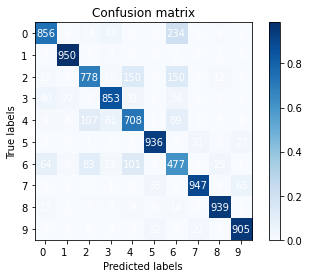

In [ ]:
Xtest = np.reshape(X_test, (10000,784))/255
y_pred = F.feedForward(Xtest)
y_test_pred = np.argmax(y_pred, axis=0)
plotConfusionMatrixUpd(y_test_pred, Y_test)

In [ ]:
# Normalize the confusion matrix
    